In [121]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# handles image data
import cv2

# handles h5 file containing the data 
import h5py

# Use for creating directories to save images (Will use in the future but not now)
import os

In [14]:
f = h5py.File('Data/matchingtDATASET_train_32.h5', mode = 'r+')

In [15]:
f.keys()

<KeysViewHDF5 ['color', 'cut', 'good', 'hole', 'metal_contamination', 'thread']>

## Get the data

In [16]:
# There does not seem to be more pythonic way to write this code

data = f['color']['angle0']

# We exclude 'angle0 as it is assigned in data'
angles = ['angle100', 'angle120', 'angle140', 'angle20', 'angle40', 'angle60', 'angle80']

for angle in angles:
    data = np.concatenate((data, f['color'][angle][()]))
    

# Redefine angles for concatenation 
angles = ['angle0', 'angle100', 'angle120', 'angle140', 'angle20', 'angle40', 'angle60', 'angle80']

# Get the data 
for name in ['cut', 'good', 'hole', 'metal_contamination', 'thread']:
    
    for angle in angles:
        
        data = np.concatenate( (data, f[name][angle][()]) )


In [17]:
data.shape

(72000, 1, 32, 32)

In [18]:
# Change the shape of the data to (72000, 32, 32, 1) instead of (72000, 1, 32, 32)
data = data[:, 0, :, :]
data = data[:, :, :, np.newaxis]

In [19]:
data.shape

(72000, 32, 32, 1)

In [20]:
# Prepare labels of the data 
y = np.array([])

for i in [0, 1, 2, 3, 4, 5]:
    
    y = np.append(y, np.tile(i, 12000))

In [21]:
Xtrain, Xtest, ytrain, ytest = train_test_split(data, y) 

In [22]:
Xtrain.shape

(54000, 32, 32, 1)

In [23]:
Xtest.shape

(18000, 32, 32, 1)

## Machine Learning

In [27]:
# Create the model
cnnModel = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), input_shape=(32, 32, 1), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(100, activation = 'relu'),
    layers.Dense(6, activation = 'softmax')])



In [28]:
optimizer = tf.keras.optimizers.Adam(0.0001)

cnnModel.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])

In [30]:
early_stopper = EarlyStopping(patience=25)

history = cnnModel.fit(x=Xtrain, y=ytrain,
                       validation_data = (Xtest, ytest),
                       epochs=100,
                       callbacks = [early_stopper])

Epoch 1/100
1688/1688 [==============================] - 30s 18ms/step - loss: 1.4405 - accuracy: 0.4004 - val_loss: 1.2960 - val_accuracy: 0.4788
Epoch 2/100
1688/1688 [==============================] - 28s 17ms/step - loss: 1.2475 - accuracy: 0.4992 - val_loss: 1.1987 - val_accuracy: 0.5096
Epoch 3/100
1688/1688 [==============================] - 29s 17ms/step - loss: 1.1790 - accuracy: 0.5281 - val_loss: 1.1560 - val_accuracy: 0.5374
Epoch 4/100
1688/1688 [==============================] - 29s 17ms/step - loss: 1.1386 - accuracy: 0.5449 - val_loss: 1.1140 - val_accuracy: 0.5531
Epoch 5/100
1688/1688 [==============================] - 29s 17ms/step - loss: 1.1083 - accuracy: 0.5584 - val_loss: 1.1040 - val_accuracy: 0.5565
Epoch 6/100
1688/1688 [==============================] - 28s 17ms/step - loss: 1.0842 - accuracy: 0.5661 - val_loss: 1.0732 - val_accuracy: 0.5742
Epoch 7/100
1688/1688 [==============================] - 29s 17ms/step - loss: 1.0612 - accuracy: 0.5778 - val_loss: 1

In [31]:
cnnModel.save("cnnModel.h5")

In [32]:
hist = pd.DataFrame(history.history)

In [118]:
hist

,loss,accuracy,val_loss,val_accuracy
0,1.440467,0.400407,1.295969,0.478833
1,1.247531,0.499222,1.198701,0.509611
2,1.178993,0.528130,1.156049,0.537389
3,1.138563,0.544852,1.114034,0.553111
4,1.108322,0.558370,1.103979,0.556500
...,...,...,...,...
95,0.048622,0.994296,0.065185,0.988833
96,0.047978,0.993926,0.068849,0.989000
97,0.044007,0.995019,0.044606,0.994778
98,0.037794,0.996815,0.039270,0.996667


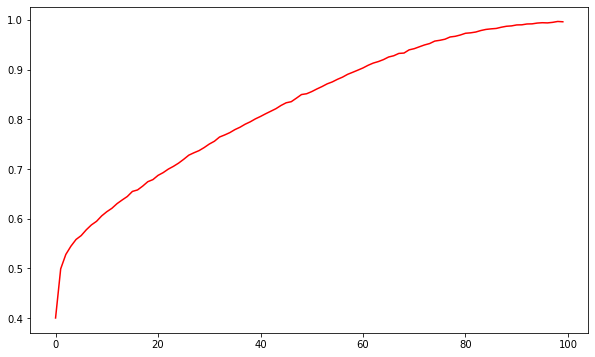

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(hist['accuracy'], color ='red')

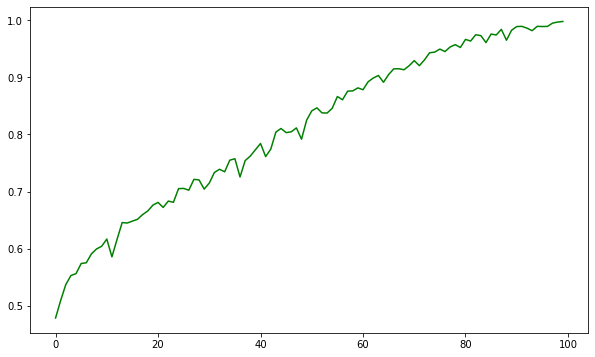

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(hist['val_accuracy'], color ='green')

In [ ]:
# We don't know exactly how the data was split meaning we can't get  classification report

## Model Evaluation

In [62]:
train_pred = np.argmax(cnnModel.predict(Xtrain), axis=1)

In [117]:
print(classification_report(ytrain, train_pred, digits=3))

              precision    recall  f1-score   support

         0.0      1.000     1.000     1.000      9031
         1.0      1.000     1.000     1.000      8915
         2.0      1.000     1.000     1.000      9032
         3.0      0.999     0.998     0.999      9053
         4.0      1.000     1.000     1.000      9002
         5.0      0.999     1.000     0.999      8967

    accuracy                          1.000     54000
   macro avg      1.000     1.000     1.000     54000
weighted avg      1.000     1.000     1.000     54000



In [64]:
test_pred = np.argmax(cnnModel.predict(Xtest), axis=1)

In [116]:
print(classification_report(ytest, test_pred, digits=3))

              precision    recall  f1-score   support

         0.0      1.000     1.000     1.000      2969
         1.0      0.999     1.000     0.999      3085
         2.0      1.000     1.000     1.000      2968
         3.0      0.997     0.992     0.994      2947
         4.0      0.996     0.998     0.997      2998
         5.0      0.995     0.996     0.995      3033

    accuracy                          0.998     18000
   macro avg      0.998     0.998     0.998     18000
weighted avg      0.998     0.998     0.998     18000



In [66]:
confusion_matrix(ytrain, train_pred)

array([[9031,    0,    0,    0,    0,    0],
       [   0, 8915,    0,    0,    0,    0],
       [   0,    0, 9032,    0,    0,    0],
       [   0,    4,    0, 9038,    3,    8],
       [   0,    0,    0,    3, 8999,    0],
       [   0,    0,    0,    3,    1, 8963]], dtype=int64)

In [67]:
confusion_matrix(ytest, test_pred)

array([[2969,    0,    0,    0,    0,    0],
       [   0, 3085,    0,    0,    0,    0],
       [   0,    0, 2968,    0,    0,    0],
       [   0,    4,    0, 2922,    5,   16],
       [   0,    0,    0,    5, 2993,    0],
       [   0,    0,    0,    5,    7, 3021]], dtype=int64)

## Predicting images to be uploaded

In [122]:
# Run this code

cnnModel = load_model("cnnModel.h5")

In [227]:
# This is the code for saving the files you will not need this.

class_labels = ['color', 'cut', 'good', 'hole', 'metal_contamination', 'thread']

for label in class_labels:
    
    cv2.imwrite(f'{label} image.png', f[label]['angle0'][0, 0, :, :][()]*255)

In [228]:
# Store the image data in uploaded_image
uploaded_image = cv2.imread(r'metal_contamination image.png', cv2.IMREAD_GRAYSCALE)

uploaded_image

array([[ 39,  38,  39, ...,  76,  93, 108],
       [ 39,  40,  41, ...,  85,  98, 109],
       [ 42,  43,  42, ...,  86, 100, 110],
       ...,
       [ 79,  83,  85, ..., 122, 114, 103],
       [ 63,  69,  74, ..., 110, 104, 101],
       [ 49,  51,  57, ...,  96,  96, 102]], dtype=uint8)

In [229]:
# Get the data in the correct format for the ML model
uploaded_image = uploaded_image/255

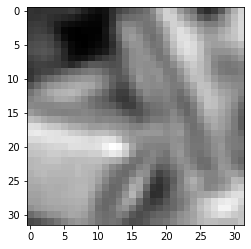

In [230]:
plt.imshow(uploaded_image, cmap='gray')

In [235]:
# Use this code for outputting probabilities of each class

cnnModel.predict(uploaded_image[np.newaxis, :, :, np.newaxis])

array([[4.5264073e-08, 6.9970191e-03, 1.7948156e-05, 4.5365957e-07,
        9.9295545e-01, 2.9030612e-05]], dtype=float32)

In [234]:
# This is the predicted class

class_labels[np.argmax(cnnModel.predict(uploaded_image[np.newaxis, :, :, np.newaxis]))]

'metal_contamination'

## Ignore the code below

In [52]:
# Figure out error

#train_pred = class_labels[ np.argmax(cnnModel.predict(Xtrain), axis=1) ]

In [79]:
script_dir = os.path.dirname(r'D:\Computer Vision\CNN Model V2')
results_dir = os.path.join(script_dir, 'Results/')


sample_file_name = "sample"

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

plt.plot([1,2,3,4])
plt.ylabel('some numbers')
plt.savefig(results_dir + sample_file_name)

#plt.imshow(f['color']['angle0'][0, 0, :, :], cmap = 'gray')
#plt.imsave(f'image_data/color/angle0/0.png', f['color']['angle0'][0, 0, :, :], cmap = 'gray')

'D:\\Computer Vision'

In [ ]:
class_labels = ['color', 'cut', 'good', 'hole', 'metal_contamination', 'thread']

angles = ['angle0', 'angle100', 'angle120', 'angle140', 'angle20', 'angle40', 'angle60', 'angle80']

for label in class_labels:    
    for angle in angles:
        f[label][angle][()]
